In [1]:
import numpy as np
import py

from py.simulation import *
from py.estimation import *
from py.features import *
from py.utils import *
from py.prep_data import *
from scipy.optimize import minimize
from importlib import reload

from numdifftools import Hessian

from matplotlib import pyplot as plt

In [30]:
t_start = 0
group = 'G1'

feature_fun = SR_quadratic_feature

In [31]:
T, timesteps, labels = prep_parakeets('data/parakeet/', group = group)
T, timesteps, A0, n_obs = initial_condition(T, timesteps, t_start = t_start)

n = len(labels)

# Maximum Likelihood

In [32]:
pars = ML(T, 
          A0, 
          feature_fun = feature_fun,
          dim = 2)
pars

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': array([0.32116554]),
 'beta': array([ 2.64192535, -1.53394755]),
 'beta_stderr': array([0.13895211, 0.10401403]),
 'LL': -2174.128824785862}

# Covariance Matrices and Coefficient of Variation

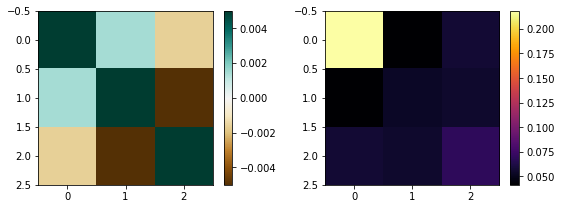

In [52]:
H = estimate_hessian(T, A0, feature_fun, pars['lam'], pars['beta'])
V = np.linalg.inv(-H)
V # covariance matrix

p = np.concatenate((pars['lam'], pars['beta']))

fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)
im = ax.imshow(V, cmap = 'BrBG', vmin = -0.005, vmax = 0.005) # estimated covariance matrix
plt.colorbar(im)
ax = fig.add_subplot(122)
im = ax.imshow(np.sqrt(V/np.outer(p,p)), cmap = 'inferno')    # coefficient of variation
plt.colorbar(im)
plt.tight_layout()

In [35]:
2*np.sqrt(np.diag(V)) # error bars on parameters

array([0.14031692, 0.28197389, 0.21262193])

# Connection rates over time

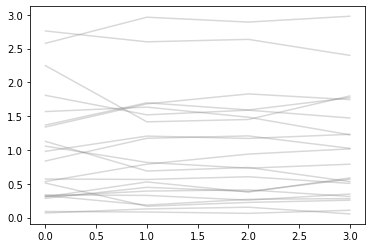

In [36]:
A = state_matrix(T, A0 = A0, lam = pars['lam'])
S = feature_fun(A)

GAMMA = softmax(S, pars['beta']).sum(axis = 1)

# GAMMA = np.sort(GAMMA, axis = 1)
p = plt.plot(GAMMA, color = 'grey', alpha = .3)

# Snapshot of the inferred model dynamics

(-0.5, 20.5, 20.5, -0.5)

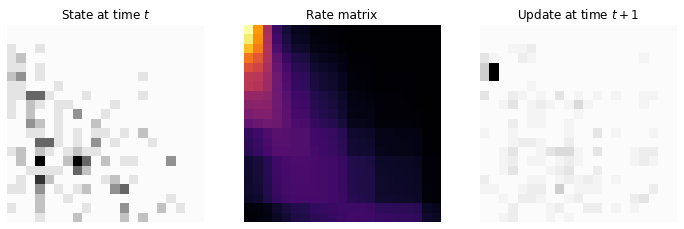

In [60]:
# snapshot of the state and cumulative hiring matrix at specified time i

i = 0

V = softmax(S, pars['beta'])[i]
# V = softmax(S, np.array([2.8, 0]))[i]

fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(131)
ax.imshow(np.ones_like(A[i]), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(A[i], -V.sum(axis = 0)), vmin = 0,   cmap = 'Greys', alpha = .99)
ax.set(title = 'State at time $t$')
ax.axis('off')

ax = fig.add_subplot(132)
# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), alpha = .995, cmap = 'inferno')
ax.set(title = 'Rate matrix')
plt.gca().axis('off')

ax = fig.add_subplot(133)
ax.imshow(np.ones_like(T[i]), cmap = 'Greys',  vmin = 0, alpha = 1)
ax.imshow(matrix_sort(T[i+1]-T[i], -GAMMA[i]),   cmap = 'Greys', alpha = .99)
ax.set(title = 'Update at time $t+1$')
ax.axis('off')
# is something wrong here? Shouldn't there be zeros on the diagonal on the rightmost plot?
# plt.colorbar()

In [57]:
# likelihood surface in parameters beta_0 and beta_1

grid = 21
M = np.zeros((grid, grid))

center = pars['beta']

X = np.linspace(center[0] - 2, center[0] + 2, grid)
Y = np.linspace(center[1] - 1, center[1] + 1, grid)
x, y = np.meshgrid(X, Y)
for i in range(grid):
    for j in range(grid):
        M[i,j] = ll(T, S, beta = np.array([x[i,j], y[i,j]]))

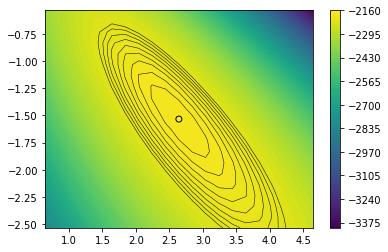

In [58]:
im = plt.contourf(x, y, M, levels = 100)

plt.contour(x, y, M, 
            levels = np.linspace(M.max() - 50, M.max(), 10),
               linewidths = .5, 
               colors = 'black', 
               linestyles = 'solid')

ix = np.where(M == M.max())
plt.scatter(X[ix[1]], Y[ix[0]], color = 'black', facecolor='none')
plt.colorbar(im)